In [99]:
%pip install torch torchvision matplotlib pandas 
%pip install transformers


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [100]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import timm
import matplotlib.pyplot as plt
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn


from torch.utils.data import DataLoader

# The device is currently optimized for MPS (Metal Performance Shaders) on macOS.
# Feel free to change it to yours locally
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

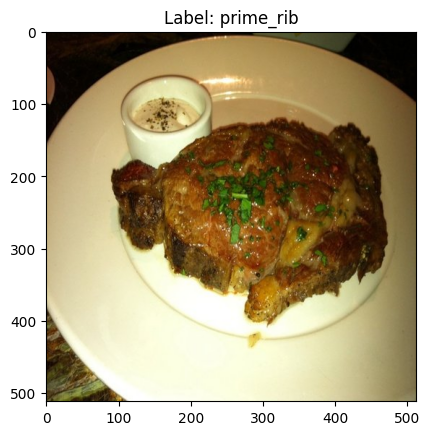

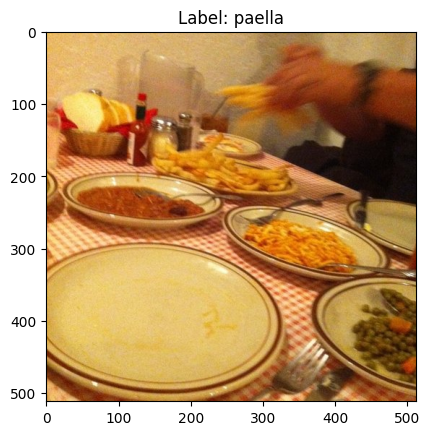

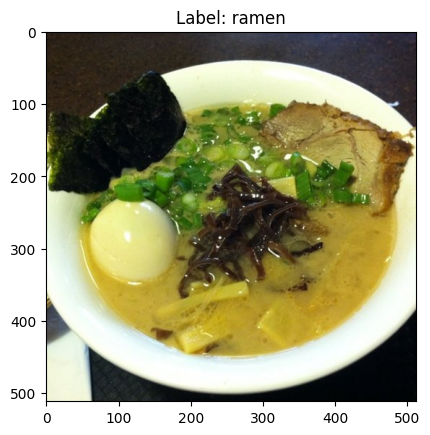

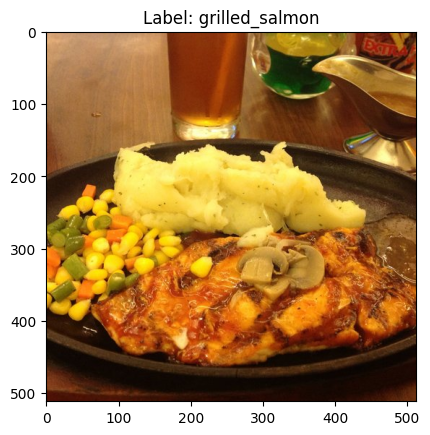

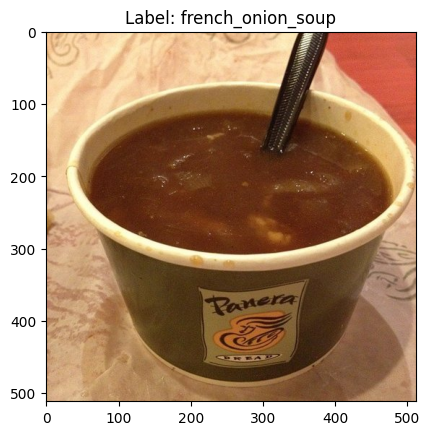

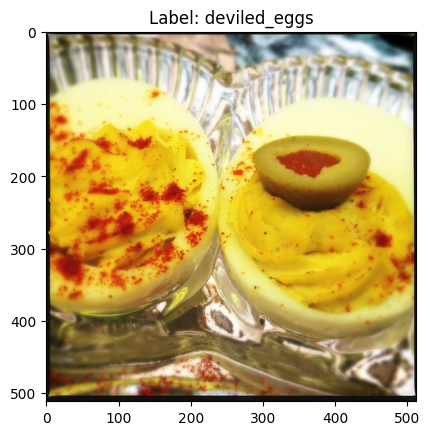

In [101]:
dataset = datasets.Food101("../data", download=True)

classes = dataset.classes
print(classes)

img_count = len(dataset._image_files)
# Print 6 random images
for _ in range(6):
  index = np.random.choice(img_count, replace=False)
  plt.imshow(dataset[index][0])
  plt.title(f"Label: {classes[dataset[index][1]]}")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1410894].


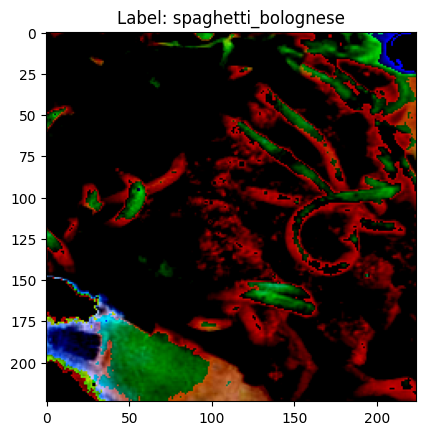

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


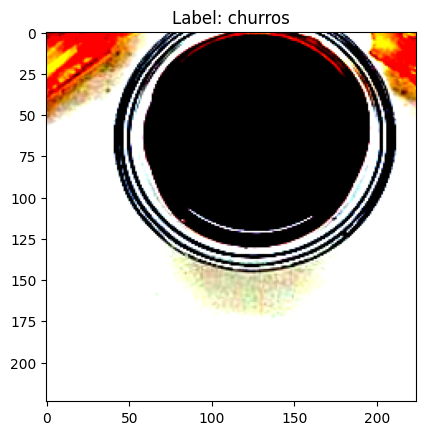

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.3262744].


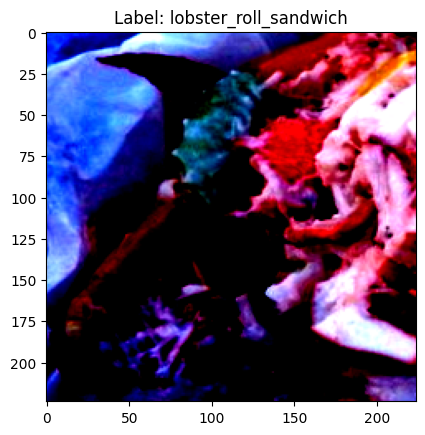

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


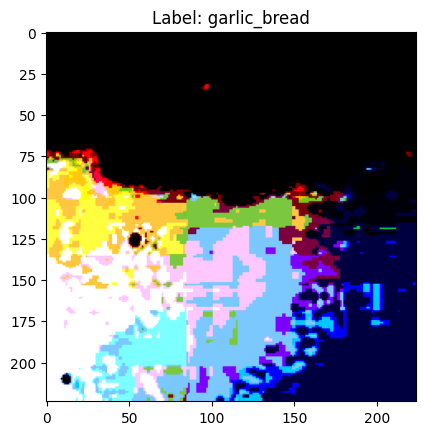

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6465361].


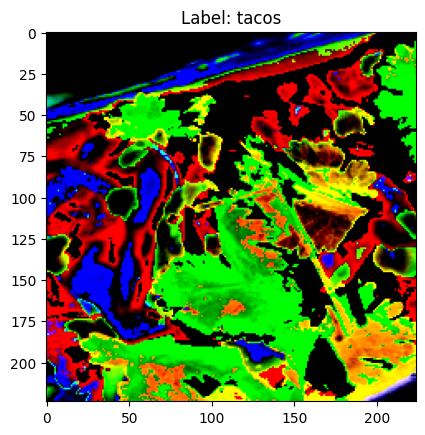

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3410363].


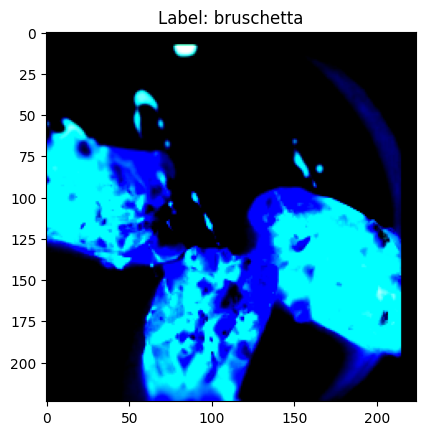

In [102]:
# Resize the images to 224x224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

dataset.transform = train_transform

for _ in range(6):
  index = np.random.choice(img_count, replace=False)
  plt.imshow(dataset[index][0].permute(1, 2, 0).numpy())
  plt.title(f"Label: {classes[dataset[index][1]]}")
  plt.show()

In [103]:
# Prepare the model
# Load from Timm instead of huggingface (Had an error)
model = timm.create_model('deit_small_patch16_224.fb_in1k', pretrained=True,num_classes=len(classes))
model = model.to(device)

# I want to test the output of the pretrained on a random image (PROTOTYPE REASONS ONLY)
index = np.random.choice(img_count, replace=False)
img, label = dataset[index]
img = img.to(device).unsqueeze(0) 
output = model(img)
print(f"Output shape: {output.shape}")
print(f"Predicted class index: {output.argmax(dim=1).item()}")
print(f"Predicted class label: {classes[output.argmax(dim=1).item()]}")
print(f"True class label: {classes[label]}")

Output shape: torch.Size([1, 101])
Predicted class index: 78
Predicted class label: poutine
True class label: hummus


In [104]:
# Split dataset 
indices = np.arange(len(dataset))
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42, shuffle=True)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 68175, Test size: 7575


In [105]:
# Data Loader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)